In [1]:
%pylab inline

import urllib2
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
from dateutil.parser import parse
import datetime

Populating the interactive namespace from numpy and matplotlib


# Buncha User Functions to sort out the messy Reddit HTML

In [2]:
def connect(url):
    hackerVoiceImIn = False
    while not hackerVoiceImIn:
        try:
            socket = urllib2.urlopen(url)
            html = socket.read()
            soup = BeautifulSoup(html, 'lxml')
            hackerVoiceImIn = True
        except:
            time.sleep(3)
            pass
    return soup

In [3]:
class CommentBox:
    def __init__(self, soup):
        self.soup = soup
    def get_soup(self):
        return self.soup
    def get_author(self):
        return self.soup.get('data-author')
    def get_neighbors(self):
        result = self.soup.find_next_siblings()[1::2]
        result = map(lambda x: CommentBox(x), result)
        return result
    def get_entry_unvoted(self):
        return self.soup.find('div', {'class':'entry unvoted'})
    def get_child(self):
        return self.soup.find('div', {'class':'child'})
    def get_comment(self):
        return EntryUnvoted(self.get_entry_unvoted()).get_comment()

In [4]:
class EntryUnvoted:
    def __init__(self, soup):
        self.soup = soup
    def get_soup(self):
        return self.soup        
    def get_comment(self):
        return str(self.soup.find('div', {'class':'md'}).get_text())
    def get_parent_comment_box(self):
        return self.soup.find_parent()
    def is_a_bargain(self):
        return (self.get_comment() in bargains)
    def get_score(self):
        score = re.compile(r'(\d+) points')
        text = self.soup.find('span', {'class': 'score likes'}).get_text()
        return int(score.findall(text)[0])
    def get_author(self):
        return CommentBox(self.get_parent_comment_box()).get_author()
    def get_time(self):
        return parse(self.soup.find('time').get('datetime'))
    def get_url(self):
        return self.soup.find('ul').find('a').get('href')

In [5]:
class Child:
    def __init__(self, soup):
        self.soup = soup
    def get_soup(self):
        return self.soup 
    def get_comment_boxes(self):
        base = CommentBox(self.soup.find('div').find('div'))
        #print base.get_neighbors()
        result = [base]
        result.extend(base.get_neighbors())
        return result

In [6]:
url = r'https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9kwuke/'
soup = connect(url)
soup.findAll('div', {'class':'entry unvoted'})

e = EntryUnvoted(soup.findAll('div', {'class': 'entry unvoted'})[1])

# The comments strings that we're after

In [7]:
bargains = ('"Dormammu, I\'ve come to bargain"\n', '"Dormammu, I\'ve come to bargain."\n')

# Want to get FilmsAreQuiteAwesome's first comment. This is our Base Case.

In [8]:
url = r'https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9kwuke/'

In [9]:
authors = ['FilmsAreQuiteAwesome']
scores = [1251]
otherComments = [0]
pages = [1]
times = [datetime.datetime(2016, 11, 4, 1, 58, 24)]
urls = [url]

In [10]:
def getBoxes(url):
    soup = connect(url)
    base = soup.findAll('div', {'class': 'entry unvoted'})[1]
    eu = EntryUnvoted(base)
    cb = CommentBox(eu.get_parent_comment_box())
    child = Child(cb.get_child())
    boxes = child.get_comment_boxes()
    nextrun = boxes
    return nextrun

In [11]:
def theLoop(nextrun):
    global authors
    global scores
    global otherComments
    global pages
    global times
    global urls
    
    base = nextrun[0]
    author = base.get_author()
    score = EntryUnvoted(base.get_entry_unvoted()).get_score()
    time = EntryUnvoted(base.get_entry_unvoted()).get_time()
    itemUrl = EntryUnvoted(base.get_entry_unvoted()).get_url()
    boxes = Child(base.get_child()).get_comment_boxes()
    nextrun = []
    neighbors = 0
    page = pages[-1]
    for box in boxes:
        try:
            neighbors += 1            
            entry = EntryUnvoted(box.get_entry_unvoted())
            if entry.is_a_bargain():
                nextrun.append(box)
        except:
            url = r'https://www.reddit.com' + entry.get_soup().find('a').get('href')

            nextrun = getBoxes(url)
            authors.append(author)
            scores.append(score)
            pages.append(page)   
            pages.append(page+1)   
            times.append(time)
            urls.append(itemUrl)
            otherComments.append(neighbors)            
            return theLoop(nextrun)
    try:
        authors.append(author)
        scores.append(score)
        pages.append(page)
        times.append(time)
        urls.append(itemUrl)
        otherComments.append(neighbors)
        return theLoop(nextrun)
    except:
        print "Done"

In [12]:
theLoop(getBoxes(url))

Done


# Build out the dataframe for the analysis

In [13]:
data = zip(authors, scores, otherComments, pages, times, urls)
df = pd.DataFrame(data, columns=['Author', 'Score', 'Children', 'Page', 'PostTime', 'URL'])
df['Diff'] = df.PostTime.diff()

In [14]:
df

,Author,Score,Children,Page,PostTime,URL,Diff
0,FilmsAreQuiteAwesome,1251,0,1,2016-11-04 01:58:24+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,NaT
1,Trionout,678,3,1,2016-11-04 01:59:15+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:51
2,MatsFan5ever,545,1,1,2016-11-04 02:00:06+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:51
3,Deofol7,472,2,1,2016-11-04 02:01:05+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:59
4,JimboJimboSlicee,439,2,1,2016-11-04 02:01:53+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:48
5,Annoying_this_guy,403,1,1,2016-11-04 02:13:34+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:11:41
6,SavioVegaGuy,368,1,1,2016-11-04 02:26:45+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:13:11
7,Torpid-O,344,1,1,2016-11-04 02:29:36+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:02:51
8,DJ-Tom-3,346,1,1,2016-11-04 02:46:22+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:16:46
9,DeoGame,358,1,1,2016-11-04 02:50:10+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:03:48


# Playground for the material

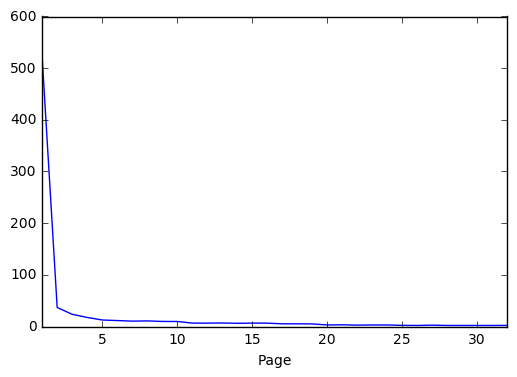

In [16]:
df.groupby('Page').Score.mean().plot()

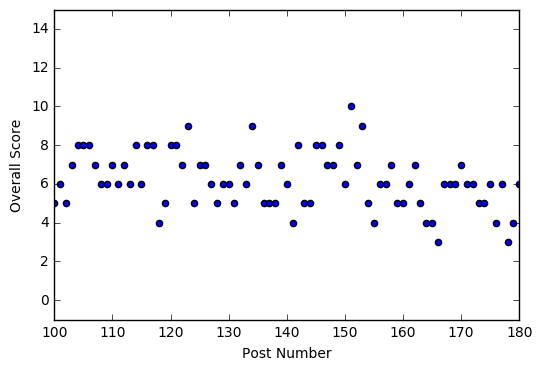

In [25]:
plt.scatter(df.index, df.Score)
plt.xlim(100, 180)
plt.ylim(-1, 15 )
plt.xlabel('Post Number')
plt.ylabel('Overall Score')

In [28]:
df.loc[140:155]

,Author,Score,Children,Page,PostTime,URL,Diff
140,ggalaximm,6,1,15,2016-11-04 11:04:07+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:04
141,ggalaximm,4,1,15,2016-11-04 11:04:10+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:03
142,ggalaximm,8,1,15,2016-11-04 11:04:15+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:05
143,ggalaximm,5,1,15,2016-11-04 11:04:19+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:04
144,ggalaximm,5,1,15,2016-11-04 11:04:23+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:04
145,ggalaximm,8,1,15,2016-11-04 11:04:28+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:05
146,ggalaximm,8,1,15,2016-11-04 11:04:32+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:04
147,ggalaximm,7,1,15,2016-11-04 11:04:37+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:05
148,ggalaximm,7,1,15,2016-11-04 11:05:00+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:23
149,ggalaximm,8,1,15,2016-11-04 11:05:04+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:04


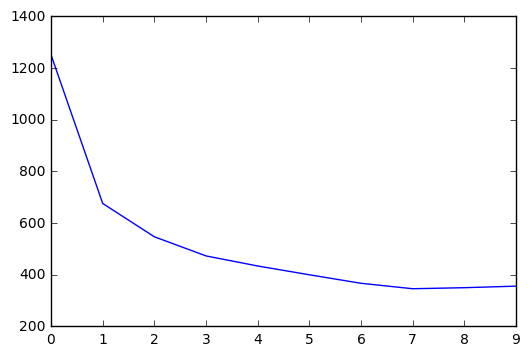

In [18]:
plt.plot(df.Score.loc[:9])

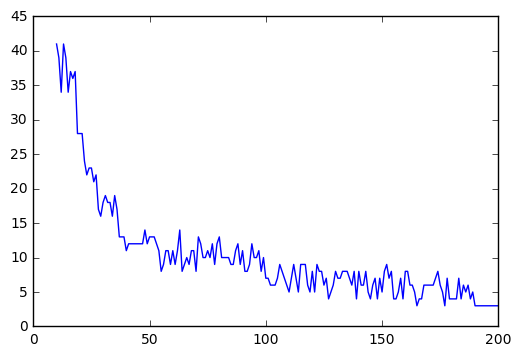

In [19]:
plt.plot(df.Score.loc[10:200])

In [23]:
responses = df[(df['Page']> 1) & (df['Children'] > 1)]
responses

,Author,Score,Children,Page,PostTime,URL,Diff
10,UltraDangerLord,40,3,2,2016-11-04 02:57:58+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:07:48
11,Velorium_Camper,38,2,2,2016-11-04 03:02:35+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:04:37
12,Brolom,36,2,2,2016-11-04 03:36:42+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:34:07
13,kinkosmyers,39,2,2,2016-11-04 03:48:49+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:12:07
14,pacmain1,39,2,2,2016-11-04 04:05:32+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:16:43
15,themexiwhite,34,2,2,2016-11-04 04:11:55+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:06:23
16,Brady_Hokes_Headset,35,2,2,2016-11-04 04:21:17+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:09:22
17,MMX2,34,2,2,2016-11-04 04:33:45+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:12:28
21,LegitTURDle,25,2,3,2016-11-04 05:11:15+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:41
152,ggalaximm,6,2,16,2016-11-04 11:05:16+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:03


In [27]:
for i in responses.index:
    print responses.loc[i, 'URL']

https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9kzed7/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9kzll8/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l0zho/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l1gmw/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l248y/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l2cui/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l2oy4/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l349c/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l4bcn/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers

In [29]:
df.Author.value_counts()

ggalaximm               185
gggalaximmm              71
antnylopz                33
rohay                     1
Torpid-O                  1
Deliwoot                  1
LegitTURDle               1
Kunfuxu                   1
slothalot                 1
SavioVegaGuy              1
kinkosmyers               1
UltraDangerLord           1
Deofol7                   1
spoodmon97                1
MichaelM_Yaa              1
MMX2                      1
themexiwhite              1
TheWistfulWanderer        1
MatsFan5ever              1
JimboJimboSlicee          1
nanoman92                 1
Brady_Hokes_Headset       1
ArcturusFlyer             1
FilmsAreQuiteAwesome      1
Annoying_this_guy         1
Trionout                  1
Velorium_Camper           1
DeoGame                   1
pacmain1                  1
1337speak                 1
wwoofless                 1
Hansmonky                 1
Brolom                    1
DJ-Tom-3                  1
Name: Author, dtype: int64

In [37]:
shitposter = df[df.Author == 'ggalaximm']

In [38]:
shitposter

,Author,Score,Children,Page,PostTime,URL,Diff
27,ggalaximm,20,1,3,2016-11-04 10:44:34+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,01:19:02
28,ggalaximm,16,1,3,2016-11-04 10:44:47+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:13
29,ggalaximm,16,1,3,2016-11-04 10:44:53+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:06
30,ggalaximm,16,1,4,2016-11-04 10:44:58+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:05
31,ggalaximm,17,1,4,2016-11-04 10:45:03+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:05
32,ggalaximm,17,1,4,2016-11-04 10:45:08+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:05
33,ggalaximm,18,1,4,2016-11-04 10:45:13+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:05
34,ggalaximm,17,1,4,2016-11-04 10:45:17+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:04
35,ggalaximm,18,1,4,2016-11-04 10:45:22+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:05
36,ggalaximm,16,1,4,2016-11-04 10:45:31+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:09


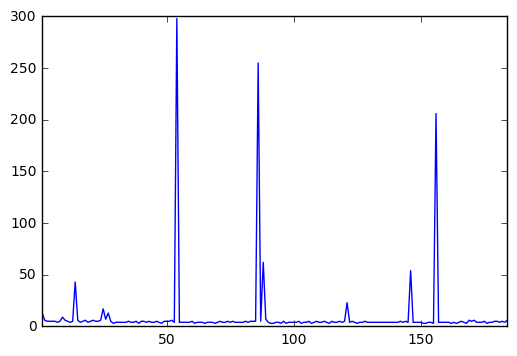

In [40]:
pd.Series(map(lambda x: int(x.seconds), shitposter.Diff)).loc[1:].plot()

In [39]:
shitposter.loc[212, 'PostTime'] - shitposter.loc[27,'PostTime']

Timedelta('0 days 00:34:17')